In [ ]:
# Importing all the necessary libraries

%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib.pyplot import figure, legend, hist, plot, title
from IPython.core.pylabtools import figsize
sns.set()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Cleaning data
1. Replaced missing values with "different".

In [ ]:
X = pd.read_table("orange_small_train.data")
# X_test = pd.read_table("orange_small_test.data")
# X = pd.concat([X_train,X_test]).reset_index(drop=True)
# X['train/test'] = 'test'
# X.loc[:X_train.shape[0]-1,'train/test'] = 'train'
# X.shape

In [ ]:
# X['train/test'].value_counts()

In [ ]:
x_var_names = X.columns
x_types = {x_var_name: X[x_var_name].dtype for x_var_name in x_var_names}

for x_var_name in x_var_names:
    if x_types[x_var_name] == int:
        x = X[x_var_name].astype(float)
        X.loc[:, x_var_name] = x
        x_types[x_var_name] = x.dtype
    elif x_types[x_var_name] != float:
        x = X[x_var_name].astype('category')
        X.loc[:, x_var_name] = x
        x_types[x_var_name] = x.dtype

# x_types

Text(0.5, 1.0, 'Proportion of Missing Values in Input Features')

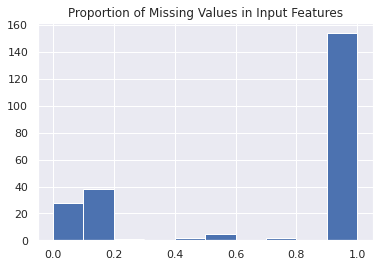

In [ ]:
nb_train_samples = len(X)

input_features_missing_proportions = X.isnull().sum() / nb_train_samples

hist(input_features_missing_proportions)
title('Proportion of Missing Values in Input Features')

In [ ]:
x_var_names = input_features_missing_proportions[input_features_missing_proportions <= .2].index

x_var_names

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227', 'Var228'], dtype='object')

In [ ]:
len(x_var_names)

66

In [ ]:
categorical_x_var_names = [x_var_name for x_var_name in x_var_names
                           if x_types[x_var_name] != float]

categorical_x_nb_levels = X[categorical_x_var_names].apply(lambda col: len(col.cat.categories))
# categorical_x_nb_levels

In [ ]:
collapsed_categories = {}
removed_categorical_x_var_names = set()

for categorical_x_var_name in categorical_x_var_names:
  
    missing_value_row_yesno = X[categorical_x_var_name].isnull()
    if missing_value_row_yesno.sum() > 0:
        X[categorical_x_var_name].cat.add_categories('missed', inplace=True)
        X.loc[missing_value_row_yesno.tolist(), categorical_x_var_name] = 'missed'

    x = X[categorical_x_var_name].copy()
    for category in x.cat.categories:
        matching_rows_yesno = x == category
        if matching_rows_yesno.sum() < .05 * nb_train_samples:
            if categorical_x_var_name in collapsed_categories:
                collapsed_categories[categorical_x_var_name].append(category) 
            else:
                collapsed_categories[categorical_x_var_name] = [category]
            if 'different' not in X[categorical_x_var_name].cat.categories:
                X[categorical_x_var_name].cat.add_categories('different', inplace=True)
            X.loc[matching_rows_yesno, categorical_x_var_name] = 'different'
            X[categorical_x_var_name].cat.remove_categories(category, inplace=True)
  
    categories = X[categorical_x_var_name].cat.categories
    if (len(categories) == 1) or\
        (len(set(categories) - set(['missed', 'different'])) < 2):
        removed_categorical_x_var_names.add(categorical_x_var_name)

categorical_x_var_names = list(set(categorical_x_var_names) - removed_categorical_x_var_names)

In [ ]:
df_clean = X[x_var_names]

x_types = {x_var_name: df_clean[x_var_name].dtype for x_var_name in x_var_names}

# x_types

In [ ]:
df_clean

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192,Var193,Var195,Var196,Var197,Var198,Var199,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var226,Var227,Var228
0,1526.0,7.0,184.0,464.0,580.0,14.0,128.0,166.56,0.0,3570.0,0.0,4.076907,9.0,36.0,35.0,1350864.0,0.0,7333.11,5.0,12.0,104.0,168.0,117625.60,1175.0,6.0,720.0,0.0,1212385.0,69134.0,185.0,0.0,9.0,397579.0,1812252.0,142.0,38418.0,0.0,0.0,different,RO12,taul,1K8T,lK27,different,different,different,9_Y1,different,VpdQ,haYg,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,XTbPUYD,different,cJvF,FzaX,different,oslk,different,jySVZNlOJy,different,RAYp,F2FyR07IdsN7I
1,525.0,0.0,0.0,168.0,210.0,2.0,24.0,353.52,0.0,4764966.0,0.0,5.408032,9.0,26.0,0.0,2872928.0,3.0,151098.90,25.0,2.0,40.0,40.0,-356411.60,590.0,72.0,0.0,8.0,4136430.0,357038.0,0.0,0.0,9.0,278334.0,10439160.0,32.0,238572.0,0.0,0.0,different,RO12,taul,1K8T,different,different,different,different,9_Y1,different,sJzTlal,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,different,different,different,FzaX,different,oslk,different,LM8l689qOp,fKCe,RAYp,F2FyR07IdsN7I
2,5236.0,7.0,904.0,1212.0,1515.0,26.0,816.0,220.08,0.0,5883894.0,0.0,6.599658,9.0,130.0,518.0,1675776.0,0.0,16211.58,40.0,58.0,312.0,336.0,405104.00,3230.0,114.0,5967.0,0.0,3478905.0,248932.0,800.0,0.0,36.0,320565.0,9826360.0,206.0,434946.0,0.0,0.0,different,different,taul,1K8T,different,different,different,different,9_Y1,different,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,uKAI,L84s,different,different,different,UYBR,FzaX,different,different,different,jySVZNlOJy,Qu4f,different,ib5G6X1eUxUn6
3,NaN,0.0,0.0,NaN,0.0,NaN,0.0,22.08,0.0,0.0,0.0,1.988250,9.0,12.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,-275703.60,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,different,RO12,taul,1K8T,different,different,different,different,9_Y1,different,VpdQ,missed,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,different,different,UYBR,FzaX,different,oslk,different,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
4,1029.0,7.0,3216.0,64.0,80.0,4.0,64.0,200.00,0.0,0.0,0.0,4.552446,18.0,82.0,224.0,784448.0,0.0,37423.50,0.0,0.0,32.0,56.0,10714.84,215.0,0.0,15111.0,0.0,150650.0,66046.0,3255.0,0.0,9.0,267162.0,644836.0,2.0,0.0,0.0,0.0,different,RO12,taul,1K8T,different,different,different,different,9_Y1,different,sJzTlal,different,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,different,different,UYBR,FzaX,different,oslk,different,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,357.0,0.0,0.0,132.0,165.0,2.0,0.0,288.08,0.0,6042420.0,0.0,2.757958,27.0,22.0,0.0,2764800.0,0.0,219451.20,20.0,0.0,32.0,32.0,85899.60,510.0,84.0,0.0,0.0,4467425.0,0.0,0.0,0.0,9.0,604800.0,10367040.0,22.0,0.0,0.0,0.0,different,RO12,taul,1K8T,different,different,different,different,9_Y1,different,VpdQ,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,different,different,cJvF,FzaX,different,oslk,different,LM8l689qOp,different,RAYp,F2FyR07IdsN7I
49996,1078.0,0.0,2736.0,380.0,475.0,2.0,88.0,166.56,0.0,0.0,0.0,0.594958,27.0,132.0,420.0,224344.0,0.0,8836.47,0.0,4.0,8.0,56.0,-1461768.00,1460.0,0.0,29862.0,0.0,1433830.0,39652.0,0.0,0.0,9.0,85120.0,1344900.0,150.0,9540.0,0.0,0.0,different,2Knk1KF,different,1K8T,JLbT,different,different,different,9_Y1,different,09_Q,sYC_,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,different,different,UYBR,FzaX,different,oslk,different,LM8l689qOp,FSa2,RAYp,55YFVY9
49997,2807.0,7.0,1460.0,568.0,710.0,4.0,328.0,166.56,0.0,42210.0,0.0,6.574023,9.0,166.0,91.0,633552.0,0.0,6124.29,5.0,24.0,112.0,152.0,105957.60,1745.0,42.0,7209.0,0.0,734845.

In [ ]:
float_x_var_names = [x_var_name for x_var_name in x_var_names
                     if x_types[x_var_name] == float]

# float_x_var_names

In [ ]:
# df_clean[float_x_var_names].std()

In [ ]:
df_clean[float_x_var_names].isnull().sum() / nb_train_samples

Var6      0.11058
Var7      0.11078
Var13     0.11078
Var21     0.11058
Var22     0.10018
Var24     0.14460
Var25     0.10018
Var28     0.10022
Var35     0.10018
Var38     0.10018
Var44     0.10018
Var57     0.00000
Var65     0.11078
Var73     0.00000
Var74     0.11078
Var76     0.10018
Var78     0.10018
Var81     0.11058
Var83     0.10018
Var85     0.10018
Var109    0.14460
Var112    0.10018
Var113    0.00000
Var119    0.11058
Var123    0.10018
Var125    0.11078
Var132    0.10018
Var133    0.10018
Var134    0.10018
Var140    0.11078
Var143    0.10018
Var144    0.11058
Var149    0.14460
Var153    0.10018
Var160    0.10018
Var163    0.10018
Var173    0.10018
Var181    0.10018
dtype: float64

In [ ]:
float_x_means = X.mean()

for float_x_var_name in float_x_var_names:
    x = df_clean[float_x_var_name]
    missing_value_row_yesno = x.isnull()
    if missing_value_row_yesno.sum() > 0:
        df_clean.loc[missing_value_row_yesno.tolist(), float_x_var_name] =\
            float_x_means[float_x_var_name]

In [ ]:
df_clean[float_x_var_names].isnull().sum() / nb_train_samples

Var6      0.0
Var7      0.0
Var13     0.0
Var21     0.0
Var22     0.0
Var24     0.0
Var25     0.0
Var28     0.0
Var35     0.0
Var38     0.0
Var44     0.0
Var57     0.0
Var65     0.0
Var73     0.0
Var74     0.0
Var76     0.0
Var78     0.0
Var81     0.0
Var83     0.0
Var85     0.0
Var109    0.0
Var112    0.0
Var113    0.0
Var119    0.0
Var123    0.0
Var125    0.0
Var132    0.0
Var133    0.0
Var134    0.0
Var140    0.0
Var143    0.0
Var144    0.0
Var149    0.0
Var153    0.0
Var160    0.0
Var163    0.0
Var173    0.0
Var181    0.0
dtype: float64

In [ ]:
categorical_x_var_names = categorical_x_nb_levels[categorical_x_nb_levels <= 500].index

# categorical_x_var_names

In [ ]:
df_clean.isna().sum()

Var6      0
Var7      0
Var13     0
Var21     0
Var22     0
Var24     0
Var25     0
Var28     0
Var35     0
Var38     0
Var44     0
Var57     0
Var65     0
Var73     0
Var74     0
Var76     0
Var78     0
Var81     0
Var83     0
Var85     0
Var109    0
Var112    0
Var113    0
Var119    0
Var123    0
Var125    0
Var132    0
Var133    0
Var134    0
Var140    0
Var143    0
Var144    0
Var149    0
Var153    0
Var160    0
Var163    0
Var173    0
Var181    0
Var192    0
Var193    0
Var195    0
Var196    0
Var197    0
Var198    0
Var199    0
Var202    0
Var203    0
Var204    0
Var205    0
Var206    0
Var207    0
Var208    0
Var210    0
Var211    0
Var212    0
Var216    0
Var217    0
Var218    0
Var219    0
Var220    0
Var221    0
Var222    0
Var223    0
Var226    0
Var227    0
Var228    0
dtype: int64

In [ ]:
df_clean.to_csv('cleaned_data.csv', index=False)
df_clean.shape

(50000, 66)

# Model Training

In [ ]:
df_clean = pd.read_csv('cleaned_data.csv')
df_clean.shape

(50000, 66)

In [ ]:
y = pd.read_csv('orange_small_train_upselling.labels', header=None)
y = y.replace(-1,0)
y.shape

(50000, 1)

In [ ]:
# Distribution of target variable shows its an highly imbalanced class problem
y.value_counts(normalize=True)

0    0.92636
1    0.07364
dtype: float64

In [ ]:
num_cols = list(df_clean.dtypes[df_clean.dtypes=='float64'].index)
cat_cols = list(df_clean.dtypes[df_clean.dtypes!='float64'].index)

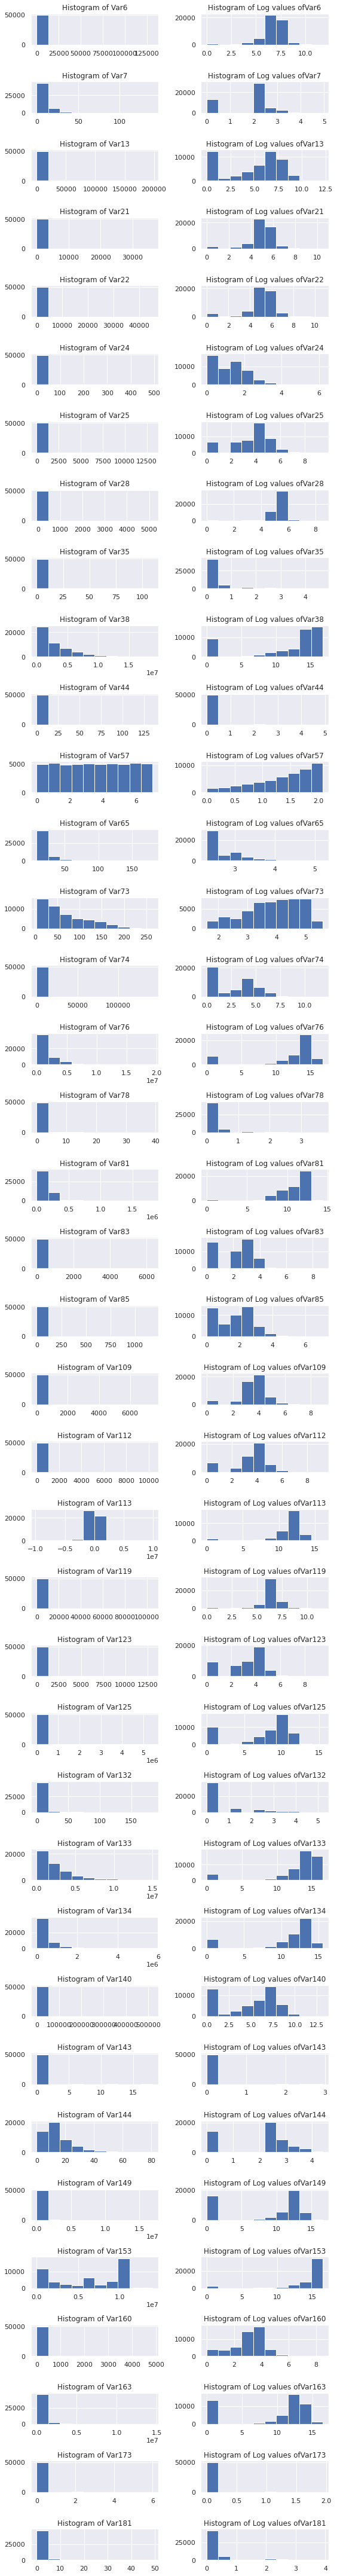

In [ ]:
fig, ax = plt.subplots(len(num_cols),2, figsize=(8,60))
# ax=ax.ravel()
for i, col in enumerate(num_cols):
  df_clean[col].hist(ax=ax[i,0])
  ax[i,0].set_title('Histogram of '+str(col)+'')
  np.log(df_clean[col]+1).hist(ax=ax[i,1])
  ax[i,1].set_title('Histogram of Log values of'+str(col)+'')

plt.tight_layout()

In [ ]:
df_clean.shape

(50000, 66)

In [ ]:
# Based on distribution plots above, we transform columns that have log-normal distribution
log_cols = list(set(num_cols)-set(['Var7', 'Var38', 'Var57', 'Var73', 'Var81', 'Var133', 'Var144', 'Var153','Var113','Var143','Var44','Var173']))
df_clean[log_cols] = df_clean[log_cols].apply(lambda col: np.log(col+1))
df_clean.shape

(50000, 66)

In [ ]:
df_clean['Var28'].fillna(df_clean['Var28'].mean(), inplace=True)
df_clean.shape

(50000, 66)

In [ ]:
# Splitting into train-test dataframes

X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.2, random_state=42)

# X_train = df_clean[df_clean['train/test']=='train']
# X_test = df_clean[df_clean['train/test']=='test']

In [ ]:
# Scaling numerical columns
ss = StandardScaler()
X_train.loc[:, num_cols] = pd.DataFrame(ss.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_test.loc[:, num_cols] = pd.DataFrame(ss.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

In [ ]:
# Performing one-hot encoding on train set
X_train = pd.get_dummies(X_train)

# Dropping columns with "Different" category to remove linear dependence between one-hot encoded columns
X_train.drop(columns=X_train.columns[X_train.columns.str.contains('different')], inplace=True)
X_train.shape

(40000, 99)

In [ ]:
# Performing one-hot encoding on test set and setting schema of test dataframe same as train set.
X_test = pd.get_dummies(X_test)
for col in list(set(X_train.columns)-set(X_test.columns)):
    X_test[col]=0
X_test = X_test[X_train.columns]
X_test.shape

(10000, 99)

# Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:,1]

Text(0.5, 0, 'FPR')

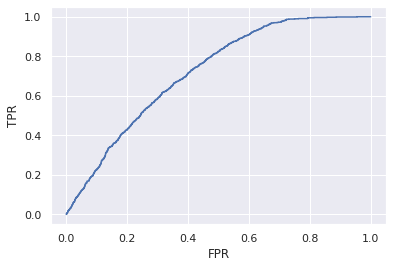

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color = 'b')
plt.ylabel('TPR')
plt.xlabel('FPR')

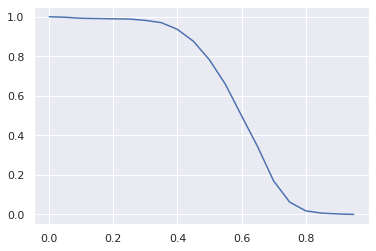

In [ ]:
recall_score_list = []
threshold_list = np.arange(0,1,0.05)
for thres in threshold_list:
  y_pred_temp = y_pred_proba.copy()
  y_pred_temp = np.where(y_pred_temp>thres, 1, 0)
  recall_score_list.append(recall_score(y_test, y_pred_temp))

plt.plot(threshold_list, recall_score_list)

In [ ]:
res = pd.DataFrame()
res['recall'] = recall_score_list
res['threshold'] = threshold_list
final_threshold = res[res['recall']>0.8].iloc[-1]['threshold']

y_pred = y_pred_proba.copy()
y_pred = np.where(y_pred>=final_threshold,1,0)

In [ ]:
print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 47.81%
F1 Score: 0.20
AUC ROC: 0.72


# Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:,1]

Text(0.5, 0, 'FPR')

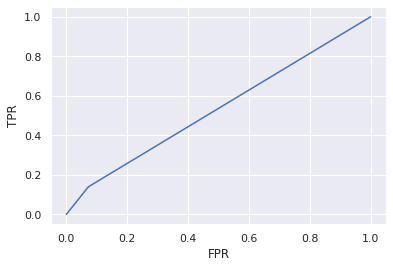

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color = 'b')
plt.ylabel('TPR')
plt.xlabel('FPR')

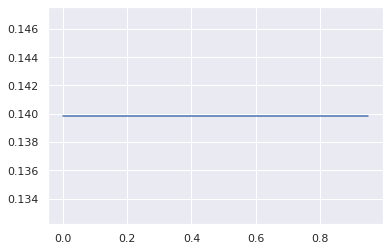

In [ ]:
recall_score_list = []
threshold_list = np.arange(0,1,0.05)
for thres in threshold_list:
  y_pred_temp = y_pred_proba.copy()
  y_pred_temp = np.where(y_pred_temp>thres, 1, 0)
  recall_score_list.append(recall_score(y_test, y_pred_temp))

plt.plot(threshold_list, recall_score_list)

In [ ]:
# res = pd.DataFrame()
# res['recall'] = recall_score_list
# res['threshold'] = threshold_list
# final_threshold = res[res['recall']>0.8].iloc[-1]['threshold']

# y_pred = y_pred_proba.copy()
# y_pred = np.where(y_pred>=final_threshold,1,0)

In [ ]:
print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 86.70%
F1 Score: 0.14
AUC ROC: 0.53


# XGBoost

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
xg = xgb.XGBClassifier(scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)
y_pred_proba = xg.predict_proba(X_test)[:,1]

Text(0.5, 0, 'FPR')

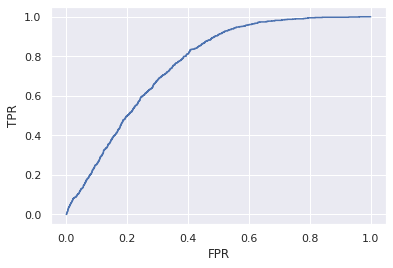

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color = 'b')
plt.ylabel('TPR')
plt.xlabel('FPR')

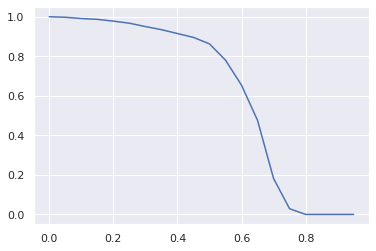

In [ ]:
recall_score_list = []
threshold_list = np.arange(0,1,0.05)
for thres in threshold_list:
  y_pred_temp = y_pred_proba.copy()
  y_pred_temp = np.where(y_pred_temp>thres, 1, 0)
  recall_score_list.append(recall_score(y_test, y_pred_temp))

plt.plot(threshold_list, recall_score_list)

In [ ]:
res = pd.DataFrame()
res['recall'] = recall_score_list
res['threshold'] = threshold_list
final_threshold = res[res['recall']>0.8].iloc[-1]['threshold']

y_pred = y_pred_proba.copy()
y_pred = np.where(y_pred>=final_threshold,1,0)

In [ ]:
print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 57.78%
F1 Score: 0.24
AUC ROC: 0.76


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]

Text(0.5, 0, 'FPR')

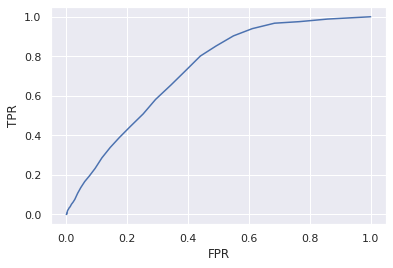

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color = 'b')
plt.ylabel('TPR')
plt.xlabel('FPR')

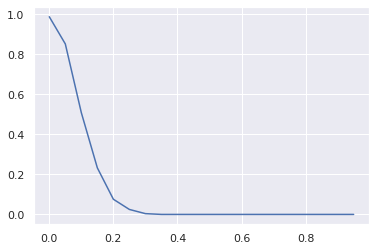

In [ ]:
recall_score_list = []
threshold_list = np.arange(0,1,0.05)
for thres in threshold_list:
  y_pred_temp = y_pred_proba.copy()
  y_pred_temp = np.where(y_pred_temp>thres, 1, 0)
  recall_score_list.append(recall_score(y_test, y_pred_temp))

plt.plot(threshold_list, recall_score_list)

In [ ]:
res = pd.DataFrame()
res['recall'] = recall_score_list
res['threshold'] = threshold_list
final_threshold = res[res['recall']>0.8].iloc[-1]['threshold']

y_pred = y_pred_proba.copy()
y_pred = np.where(y_pred>=final_threshold,1,0)

In [ ]:
print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 48.54%
F1 Score: 0.21
AUC ROC: 0.73


logistic regression: Polynomial Regression 

In [ ]:
from sklearn.model_selection import GridSearchCV
import joblib

# Finding best parameters for the Models using GridSearch

**AUC-ROC is a better metric than F1 in this case since our probability scores might be used to priortize efforts of calling/promotions team and AUC-ROC helps us to reduce impurities (target variable=0) at a higher probability score. Thus, giving us different categories of leads (Hot/Warm/Cold) based on their probability scores to run differential promotions.**

## Logistic Regression

In [ ]:
penalty = ['l1','l2']
C = [10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3]

hyperF = dict(penalty=penalty,C=C) #, 
lr = LogisticRegression(class_weight='balanced')
gridF = GridSearchCV(lr, hyperF, cv = 5, verbose = 10, n_jobs = -1, scoring='roc_auc')
bestF = gridF.fit(X_train, y_train)
print(bestF.best_params_)
print(bestF.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'C': 0.01, 'penalty': 'l2'}
0.7096394608982115


In [ ]:
model = bestF.best_estimator_
joblib.dump(model, 'Logistic_Regression_Best_model.pkl')

['Logistic_Regression_Best_model.pkl']

In [ ]:
model = bestF.best_estimator_
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 56.72%
F1 Score: 0.21
AUC ROC: 0.72


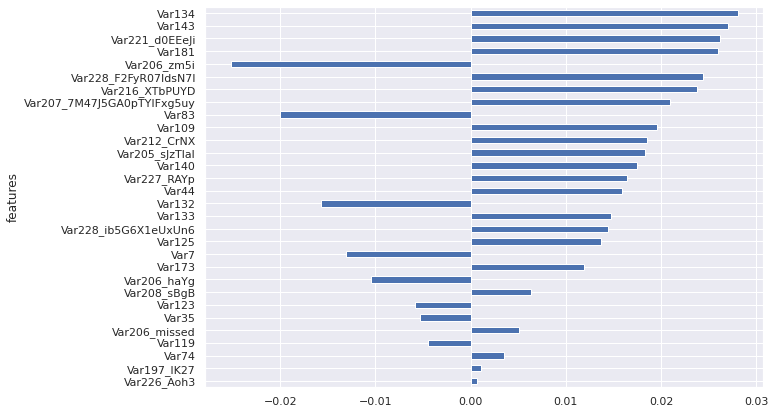

In [ ]:
res = pd.DataFrame()
res['features'] = list(X_train.columns)
res['coef'] = bestF.best_estimator_.coef_.tolist()[0]
res['abs_coef'] = np.abs(res['coef'])
res.set_index('features').sort_values(['abs_coef'], ascending='False').head(30)['coef'].plot(kind='barh', figsize=(10,7))

## Polynomial Regression

In [ ]:
penalty = ['l1','l2']
C = [10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3]

poly = PolynomialFeatures(degree=2)
X_poly_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly_val = pd.DataFrame(poly.fit_transform(X_test), columns=poly.get_feature_names(X_train.columns))

hyperF = dict(penalty=penalty,C=C) #, 
lr = LogisticRegression(fit_intercept=False, class_weight='balanced')
gridF = GridSearchCV(lr, hyperF, cv = 5, verbose = 10, n_jobs = -1, scoring='roc_auc')
bestF = gridF.fit(X_poly_train, y_train)
print(bestF.best_params_)
print(bestF.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'C': 0.01, 'penalty': 'l2'}
0.6811189519991221


In [ ]:
model = bestF.best_estimator_
joblib.dump(model, 'Polynomial_Regression_Best_model.pkl')

['Polynomial_Regression_Best_model.pkl']

In [ ]:
model = bestF.best_estimator_
y_pred = model.predict(X_poly_val)
y_pred_proba = model.predict_proba(X_poly_val)[:,1]

print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 67.25%
F1 Score: 0.22
AUC ROC: 0.71


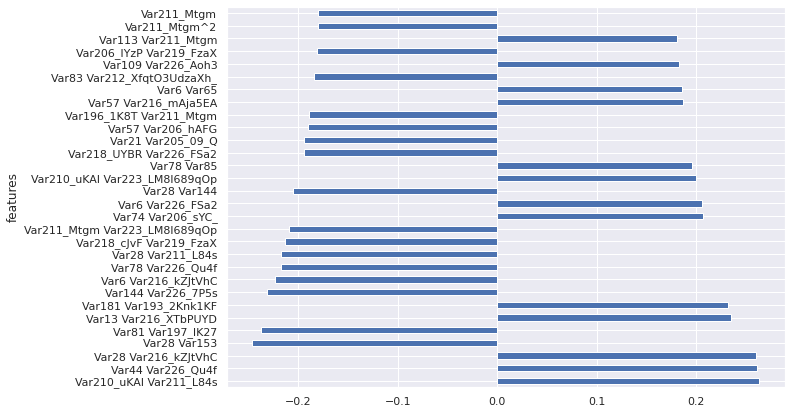

In [ ]:
res = pd.DataFrame()
res['features'] = list(X_poly_train.columns)
res['coef'] = bestF.best_estimator_.coef_.tolist()[0]
res['abs_coef'] = np.abs(res['coef'])
res.sort_values('abs_coef', ascending=False).head(30).set_index('features')['coef'].plot(kind='barh', figsize=(10,7))

# XGBoost

In [ ]:
n_estimators = [100,250]
max_depth = [3,5,7]
eta = [0.15]
gamma = [0]
min_child_weight = [1]
subsample = [0.9,1]
reg_lambda = [1] #
reg_alpha = [0] #,5
colsample_bytree = [1] #
colsample_bylevel = [1]
colsample_bynode = [1]
scale_pos_weight = [y_train.value_counts()[0]/y_train.value_counts()[1]]
# min_samples_split = [2,4,8]
# min_samples_leaf = [2,4,8] 
# max_features = ['auto']
# class_weight = ['balanced']

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, 
              eta=eta, reg_lambda=reg_lambda, reg_alpha=reg_alpha, colsample_bytree= colsample_bytree,
              colsample_bylevel = colsample_bylevel, colsample_bynode= colsample_bynode,
              gamma = gamma, scale_pos_weight= scale_pos_weight,
             min_child_weight = min_child_weight, subsample = subsample) #, 

model_xgb = xgb.XGBClassifier()

gridF = GridSearchCV(model_xgb, hyperF, cv = 5, verbose = 10, n_jobs = -1, scoring='roc_auc')
bestF = gridF.fit(X_train, y_train)
print(bestF.best_params_)
print(bestF.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.15, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 12.712718546451834, 'subsample': 0.9}
0.7480065390377096


In [ ]:
bestF.best_estimator_

XGBClassifier(eta=0.15, scale_pos_weight=12.712718546451834, subsample=0.9)

In [ ]:
model = bestF.best_estimator_
joblib.dump(model, 'XGBoost_Best_model.pkl')

['XGBoost_Best_model.pkl']

In [ ]:
model = bestF.best_estimator_
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 58.53%
F1 Score: 0.24
AUC ROC: 0.76


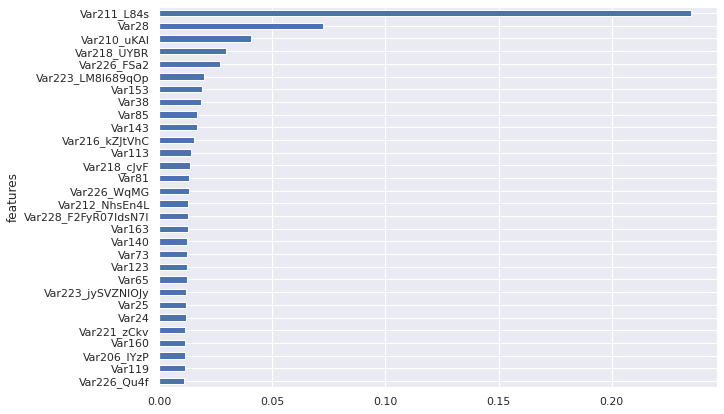

In [ ]:
res = pd.DataFrame()
res['features'] = list(X_train.columns)
res['coef'] = bestF.best_estimator_.feature_importances_.tolist()
res['abs_coef'] = np.abs(res['coef'])
res.sort_values('abs_coef').tail(30).set_index('features')['coef'].plot(kind='barh', figsize=(10,7))

# Final Model

Choosing XGBoost as our final model since it has highest AUC.

In [ ]:
xg = xgb.XGBClassifier(eta=0.15, scale_pos_weight=12.712718546451834, subsample=0.9)
xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)
y_pred_proba = xg.predict_proba(X_test)[:,1]

Text(0.5, 0, 'FPR')

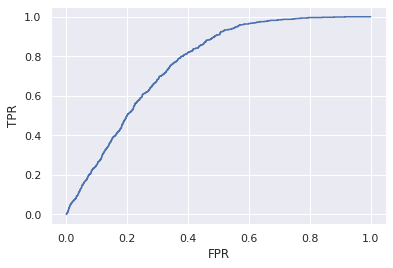

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color = 'b')
plt.ylabel('TPR')
plt.xlabel('FPR')

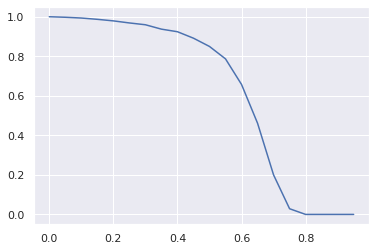

In [ ]:
recall_score_list = []
threshold_list = np.arange(0,1,0.05)
for thres in threshold_list:
  y_pred_temp = y_pred_proba.copy()
  y_pred_temp = np.where(y_pred_temp>thres, 1, 0)
  recall_score_list.append(recall_score(y_test, y_pred_temp))

plt.plot(threshold_list, recall_score_list)

In [ ]:
res = pd.DataFrame()
res['recall'] = recall_score_list
res['threshold'] = threshold_list
final_threshold = res[res['recall']>0.8].iloc[-1]['threshold']

y_pred = y_pred_proba.copy()
y_pred = np.where(y_pred>=final_threshold,1,0)

In [ ]:
print(f'Overall model accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
print(f'AUC ROC: {roc_auc_score(y_test, y_pred_proba):.2f}')

Overall model accuracy: 58.53%
F1 Score: 0.24
AUC ROC: 0.76


(array([1999.,  819.,  726.,  604.,  497.,  536., 1056., 1579., 1788.,
         396.]),
 array([0.01245356, 0.09150285, 0.17055213, 0.24960142, 0.3286507 ,
        0.4077    , 0.4867493 , 0.5657986 , 0.64484787, 0.72389716,
        0.80294645], dtype=float32),
 <a list of 10 Patch objects>)

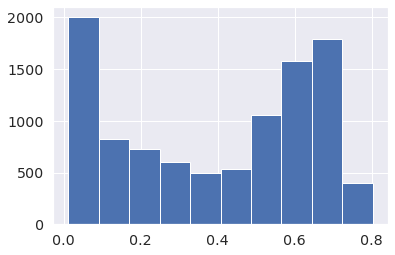

In [ ]:
plt.hist(y_pred_proba)

In [ ]:
res_df = pd.DataFrame()
res_df['pred_prob'] = y_pred_proba
res_df['target_var'] = y_test
res_df['pred_prob_bucket'] = pd.cut(res_df['pred_prob'], bins=np.arange(0,1,0.1))
res_df = pd.concat([res_df.groupby('pred_prob_bucket')['target_var'].mean()*100, res_df.groupby('pred_prob_bucket')['target_var'].size()], axis=1)
res_df.columns=['Conversion_Percentage','Num of datapoints']
res_df

,Conversion_Percentage,Num of datapoints
pred_prob_bucket,,
"(0.0, 0.1]",7.962529,2078
"(0.1, 0.2]",5.940594,1041
"(0.2, 0.3]",7.821229,850
"(0.3, 0.4]",5.223881,621
"(0.4, 0.5]",7.051282,728
"(0.5, 0.6]",10.367893,1550
"(0.6, 0.7]",8.786611,2290
"(0.7, 0.8]",9.580838,841
"(0.8, 0.9]",0.000000,1


In [ ]:
y_test.value_counts()

0    9235
1     765
dtype: int64

In [ ]:
pd.Series(y_pred).value_counts()

0    5318
1    4682
dtype: int64

In [ ]:
cm_test = confusion_matrix(y_test, y_pred)

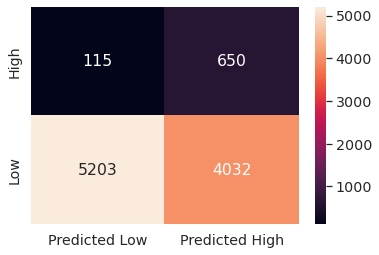

In [ ]:
df_cm = pd.DataFrame(cm_test, index = ['Low','High'],columns = ['Predicted Low','Predicted High'])

sns.set(font_scale=1.3)
sns.heatmap(df_cm.iloc[-1::-1,:], annot=True,fmt= 'g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.56      0.72      9235
           1       0.14      0.85      0.24       765

    accuracy                           0.59     10000
   macro avg       0.56      0.71      0.48     10000
weighted avg       0.91      0.59      0.68     10000



EDA on Data
1. In Exploratory data analysis, we see the inter-relationships and insights from the response and predictor variable

In [ ]:
#Merging predictor and response variable to obtain data
df_response=pd.DataFrame(y)
df1=pd.concat([df_response,df_clean], axis=1, ignore_index=True)
df1.head()

NameError: ignored